## Some comparisons of filtering and smoothing (can be with or without the viewer)

### Hint for your task 2)
#### You must implement your filtering / smoothing in the HMMFilter / HMMSmoother classes in the file Filters. For the filter, this means also that you can use the visualisation through the Localizer, but you can call filter / smooth also directly from here, without the Localiser. Note also, that you must make use of the given models and the robot simulator in RobotSim!


In [ ]:
# In this cell, you can write your own "main" to run and evaluate your 
# implementation without using the visualisation (should be considerably faster!)

from models import *
from Filters import HMMFilter, HMMSmoother

import numpy as np
import matplotlib.pyplot as plt
import random

# ...  

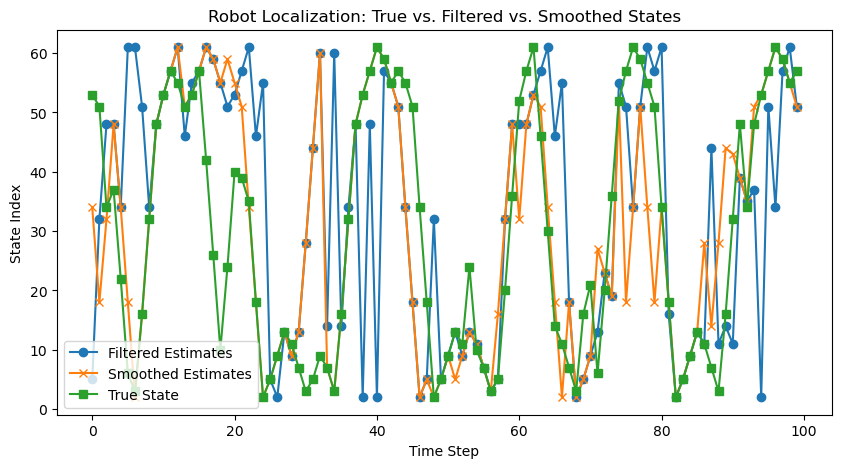

nbr of moves: 100, avg error: 1.87, nbr correct guesses: 32


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from models import StateModel
from Filters import HMMFilter, HMMSmoother
from models import RobotSim
from models import TransitionModel
from models import ObservationModel_NUF
from models import ObservationModel_UF

# Grid size
ROWS, COLS = 4, 4
state_model = StateModel(ROWS, COLS)
transition_model = TransitionModel(state_model)

# Choose observation model (set to True for UF, False for NUF)
USE_UNIFORM_FAILURE = False
if USE_UNIFORM_FAILURE:
    observation_model = ObservationModel_UF.ObservationModelUF(state_model)
else:
    observation_model = ObservationModel_NUF.ObservationModel(state_model)

# Initialize robot simulator
true_state = random.randint(0, state_model.get_num_of_states() - 1)
robot = RobotSim(true_state, state_model)

# Initial uniform belief
num_states = state_model.get_num_of_states()
belief = np.ones(num_states) / num_states

# Initialize HMM filter and smoother
hmm_filter = HMMFilter(belief, transition_model, observation_model, state_model)
hmm_smoother = HMMSmoother(transition_model, observation_model, state_model)

# Number of steps to simulate
num_steps = 100
sensor_readings = []
filtered_estimates = []
true_estimates = []
filtered_beliefs = []  # Store full probability distributions

# Run forward filtering
for _ in range(num_steps):
    true_state = robot.move_once(transition_model)
    true_estimates.append(true_state)
    
    sensor_reading = robot.sense_in_current_state(observation_model)
    sensor_readings.append(sensor_reading)
    
    belief = hmm_filter.filter(sensor_reading)
    filtered_estimates.append(np.argmax(belief))
    filtered_beliefs.append(belief)  # Store full belief distribution

# Convert to numpy array for smoothing
filtered_beliefs = np.array(filtered_beliefs).T  # Shape (num_states, num_steps)

# Run smoothing
smoothed_beliefs = hmm_smoother.smooth(sensor_readings, filtered_beliefs)
smoothed_estimates = np.argmax(smoothed_beliefs, axis=0)  # Get most likely states

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(num_steps), filtered_estimates, label="Filtered Estimates", marker='o')
plt.plot(range(num_steps), smoothed_estimates, label="Smoothed Estimates", marker='x')
plt.plot(range(num_steps), true_estimates, label="True State", marker='s')
plt.xlabel("Time Step")
plt.ylabel("State Index")
plt.title("Robot Localization: True vs. Filtered vs. Smoothed States")
plt.legend()
plt.show()

# Compute and print evaluation statistics (using the filtered estimates)
total_moves = num_steps
total_error = 0
correct_guesses = 0

for i in range(total_moves):
    # Convert state indices to positions (ignoring heading)
    true_pos = state_model.state_to_position(true_estimates[i])
    est_pos = state_model.state_to_position(filtered_estimates[i])
    error = abs(true_pos[0] - est_pos[0]) + abs(true_pos[1] - est_pos[1])
    total_error += error
    if error == 0:
        correct_guesses += 1

avg_error = total_error / total_moves

print(f"nbr of moves: {total_moves}, avg error: {avg_error}, nbr correct guesses: {correct_guesses}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from models import StateModel
from Filters import HMMFilter, HMMSmoother
from models import RobotSim
from models import TransitionModel
from models import ObservationModel_NUF
from models import ObservationModel_UF

def manhattan_error(state_model, state_est, state_true):
    """Compute Manhattan error (ignoring heading) between two state indices."""
    pos_est = state_model.state_to_position(state_est)
    pos_true = state_model.state_to_position(state_true)
    return abs(pos_est[0] - pos_true[0]) + abs(pos_est[1] - pos_true[1])

def simulate_scenario(ROWS, COLS, obs_model_type, method, num_steps=500):
    """
    Simulate robot localization for a given scenario.
    
    Parameters:
      - ROWS, COLS: grid dimensions.
      - obs_model_type: 'NUF' or 'UF'
      - method: 'filter' (forward filtering), 'sensor' (sensor output only), or 'smoother' (forward-backward smoothing with window=5).
      - num_steps: number of simulation steps.
      
    Returns:
      - running_avg_errors: list of cumulative average Manhattan errors (per move).
      - total_moves: total number of moves simulated.
      - correct_guesses: number of moves with zero error.
    """
    # Create state model and transition model
    state_model = StateModel(ROWS, COLS)
    transition_model = TransitionModel(state_model)
    
    # Select observation model
    if obs_model_type == 'UF':
        observation_model = ObservationModel_UF.ObservationModelUF(state_model)
    else:  # default to NUF
        observation_model = ObservationModel_NUF.ObservationModel(state_model)
    
    # Initialize robot simulator with a random true state
    true_state = random.randint(0, state_model.get_num_of_states() - 1)
    robot = RobotSim(true_state, state_model)
    
    # Initial uniform belief for filtering/smoothing
    num_states = state_model.get_num_of_states()
    belief = np.ones(num_states) / num_states

    # Initialize HMM filter and smoother (for filter and smoother methods)
    hmm_filter = HMMFilter(belief.copy(), transition_model, observation_model, state_model)
    # For smoother, we will store the full belief history
    filtered_beliefs = []
    
    running_errors = []
    cumulative_error = 0.0
    correct_guesses = 0
    moves_count = 0
    
    # For sensor-only method, we need to count only valid sensor readings
    valid_moves = 0
    cumulative_error_sensor = 0.0
    
    # For storing estimates for smoothing method
    filtered_estimates = []  # argmax from filtering per step
    sensor_readings = []     # sensor readings per step
    true_states = []         # true state indices per step
    
    # Simulation loop
    for step in range(num_steps):
        # Move the robot
        true_state = robot.move_once(transition_model)
        true_states.append(true_state)
        
        # Obtain sensor reading (could be None, but assignment says always update)
        sensor_reading = robot.sense_in_current_state(observation_model)
        sensor_readings.append(sensor_reading)
        
        if method == 'sensor':
            # Sensor output only: if sensor reading is not None, use reference state
            if sensor_reading is not None:
                est_state = state_model.reading_to_ref_state(sensor_reading)
                error = manhattan_error(state_model, est_state, true_state)
                valid_moves += 1
                cumulative_error_sensor += error
            else:
                # When sensor reports nothing, we skip error counting
                est_state = None
                error = None
        elif method == 'filter':
            # Forward filtering: update the belief and use argmax
            belief = hmm_filter.filter(sensor_reading)
            est_state = np.argmax(belief)
            error = manhattan_error(state_model, est_state, true_state)
            # Save full belief for potential smoothing later
            filtered_beliefs.append(belief)
            filtered_estimates.append(est_state)
        elif method == 'smoother':
            # We run forward filtering and store full beliefs
            belief = hmm_filter.filter(sensor_reading)
            filtered_beliefs.append(belief)
            filtered_estimates.append(np.argmax(belief))
            # Smoother will be applied later using a sliding window.
            # For now, we compute error using forward filter estimate.
            est_state = np.argmax(belief)
            error = manhattan_error(state_model, est_state, true_state)
        else:
            raise ValueError("Invalid method specified.")
        
        moves_count += 1
        # For methods filter and smoother, always count error
        if method in ['filter', 'smoother']:
            cumulative_error += error
            if error == 0:
                correct_guesses += 1
        
        # For sensor-only, if valid move, update cumulative error separately
        if method == 'sensor' and sensor_reading is not None:
            # Already updated cumulative_error_sensor and valid_moves
            pass
        
        # Record running average error
        if method == 'sensor':
            avg_err = cumulative_error_sensor / valid_moves if valid_moves > 0 else 0
        else:
            avg_err = cumulative_error / moves_count
        running_errors.append(avg_err)
    
    # For smoother method, apply sliding window smoothing with window=5
    if method == 'smoother':
        # Define sliding window smoother (window length = 5)
        window = 5
        filtered_beliefs = np.array(filtered_beliefs).T  # shape (num_states, num_steps)
        smoothed_beliefs = np.zeros_like(filtered_beliefs)
        num_states, T = filtered_beliefs.shape
        # For t < window, use filtered belief
        for t in range(T):
            if t < window - 1:
                smoothed_beliefs[:, t] = filtered_beliefs[:, t]
            else:
                # Apply forward-backward smoothing on window [t-window+1, t]
                segment_length = window
                f_segment = filtered_beliefs[:, t - window + 1:t + 1].copy()  # shape (num_states, window)
                b_segment = np.ones((num_states, segment_length))
                T_mat = transition_model.get_T()
                # Backward pass on the segment
                for k in range(segment_length - 2, -1, -1):
                    O_next = observation_model.get_o_reading(sensor_readings[t - window + 1 + k + 1])
                    b_segment[:, k] = T_mat @ (O_next @ b_segment[:, k + 1])
                    # Normalize backward message
                    b_segment[:, k] /= np.sum(b_segment[:, k]) if np.sum(b_segment[:, k]) > 0 else 1
                # Smoothed belief at time t is f_segment[:, -1] * b_segment[:, -1] (normalized)
                smoothed = f_segment[:, -1] * b_segment[:, -1]
                smoothed /= np.sum(smoothed) if np.sum(smoothed) > 0 else 1
                smoothed_beliefs[:, t] = smoothed
        # Replace estimated states with smoothed estimates and recompute error metrics
        smoothed_estimates = np.argmax(smoothed_beliefs, axis=0)
        # Recompute cumulative error and correct guesses using smoothed estimates
        cumulative_error = 0.0
        correct_guesses = 0
        for t in range(T):
            err = manhattan_error(state_model, smoothed_estimates[t], true_states[t])
            cumulative_error += err
            if err == 0:
                correct_guesses += 1
            running_errors[t] = cumulative_error / (t + 1)
        moves_count = T
    
    return running_errors, moves_count, correct_guesses

# ====================
# Scenario 1:
# 8x8 grid: Compare Forward Filtering (NUF) vs Sensor Output Only (NUF)
running_err_filter, moves_filter, correct_filter = simulate_scenario(8, 8, 'NUF', 'filter', num_steps=500)
running_err_sensor, moves_sensor, correct_sensor = simulate_scenario(8, 8, 'NUF', 'sensor', num_steps=500)

plt.figure(figsize=(10, 6))
plt.plot(running_err_filter, label="Forward Filtering (NUF)")
plt.plot(running_err_sensor, label="Sensor Output Only (NUF)")
plt.xlabel("Time Step")
plt.ylabel("Running Avg. Manhattan Error")
plt.title("Scenario 1: 8x8 Grid, NUF - Filtering vs Sensor Only")
plt.legend()
plt.show()

print(f"Scenario 1 - Filtering: nbr of moves: {moves_filter}, avg error: {running_err_filter[-1]}, nbr correct guesses: {correct_filter}")
print(f"Scenario 1 - Sensor Only: nbr of moves: {moves_sensor}, avg error: {running_err_sensor[-1]}, nbr correct guesses: {correct_sensor}")

# ====================
# Scenario 2:
# 4x4 grid: Compare Forward Filtering with NUF vs Forward Filtering with UF
running_err_filter_NUF, moves_filter_NUF, correct_filter_NUF = simulate_scenario(4, 4, 'NUF', 'filter', num_steps=500)
running_err_filter_UF, moves_filter_UF, correct_filter_UF = simulate_scenario(4, 4, 'UF', 'filter', num_steps=500)

plt.figure(figsize=(10, 6))
plt.plot(running_err_filter_NUF, label="Forward Filtering (NUF)")
plt.plot(running_err_filter_UF, label="Forward Filtering (UF)")
plt.xlabel("Time Step")
plt.ylabel("Running Avg. Manhattan Error")
plt.title("Scenario 2: 4x4 Grid, Forward Filtering: NUF vs UF")
plt.legend()
plt.show()

print(f"Scenario 2 - NUF: nbr of moves: {moves_filter_NUF}, avg error: {running_err_filter_NUF[-1]}, nbr correct guesses: {correct_filter_NUF}")
print(f"Scenario 2 - UF: nbr of moves: {moves_filter_UF}, avg error: {running_err_filter_UF[-1]}, nbr correct guesses: {correct_filter_UF}")

# ====================
# Scenario 3:
# 16x20 grid: Compare Forward Filtering with NUF vs Forward Filtering with UF
running_err_filter_NUF_16x20, moves_filter_NUF_16x20, correct_filter_NUF_16x20 = simulate_scenario(16, 20, 'NUF', 'filter', num_steps=500)
running_err_filter_UF_16x20, moves_filter_UF_16x20, correct_filter_UF_16x20 = simulate_scenario(16, 20, 'UF', 'filter', num_steps=500)

plt.figure(figsize=(10, 6))
plt.plot(running_err_filter_NUF_16x20, label="Forward Filtering (NUF)")
plt.plot(running_err_filter_UF_16x20, label="Forward Filtering (UF)")
plt.xlabel("Time Step")
plt.ylabel("Running Avg. Manhattan Error")
plt.title("Scenario 3: 16x20 Grid, Forward Filtering: NUF vs UF")
plt.legend()
plt.show()

print(f"Scenario 3 - NUF: nbr of moves: {moves_filter_NUF_16x20}, avg error: {running_err_filter_NUF_16x20[-1]}, nbr correct guesses: {correct_filter_NUF_16x20}")
print(f"Scenario 3 - UF: nbr of moves: {moves_filter_UF_16x20}, avg error: {running_err_filter_UF_16x20[-1]}, nbr correct guesses: {correct_filter_UF_16x20}")

# ====================
# Scenario 4:
# 10x10 grid: Compare Forward Filtering (NUF) vs Forward-Backward Smoothing (window=5, NUF)
running_err_filter_10x10, moves_filter_10x10, correct_filter_10x10 = simulate_scenario(10, 10, 'NUF', 'filter', num_steps=500)
running_err_smoother_10x10, moves_smoother_10x10, correct_smoother_10x10 = simulate_scenario(10, 10, 'NUF', 'smoother', num_steps=500)

plt.figure(figsize=(10, 6))
plt.plot(running_err_filter_10x10, label="Forward Filtering (NUF)")
plt.plot(running_err_smoother_10x10, label="Forward-Backward Smoothing (NUF, window=5)")
plt.xlabel("Time Step")
plt.ylabel("Running Avg. Manhattan Error")
plt.title("Scenario 4: 10x10 Grid, Filtering vs Smoothing (NUF)")
plt.legend()
plt.show()

print(f"Scenario 4 - Filtering: nbr of moves: {moves_filter_10x10}, avg error: {running_err_filter_10x10[-1]}, nbr correct guesses: {correct_filter_10x10}")
print(f"Scenario 4 - Smoothing: nbr of moves: {moves_smoother_10x10}, avg error: {running_err_smoother_10x10[-1]}, nbr correct guesses: {correct_smoother_10x10}")
